# Gemicai tutorial 5: Advanced ClassifierTree
In this tutorial we'll go a bit more in depth about what the ClassifierTree can do.

In [1]:
import gemicai as gem
import torch
import torchvision.models as models

## 5.1 Recap
In the previous tutorial, we have learned about the concept and core functionality of ClassifierTree, in this tutorial, we'll go more in depth on how to actually make it work. But first, a quick recap of everything we need from tutorial 4.

### Load tree
In this example we'll be taking a look at the ClassifierTree that determines the StudyDescription for images from the DX modality.

In [2]:
tree_path = '/mnt/SharedStor/trees/dx_tree'

tree = gem.ClassifierTree.from_dir(tree_path)

print(tree)

|   Depth | Label            |   Classifiers |   Avg. classes |
|---------+------------------+---------------+----------------|
|       0 | BodyPartExamined |             1 |           21   |
|       1 | StudyDescription |            20 |            9.2 |



### Initialize gemsets
To train and evaluate a tree, we first need to create a training- and test-dataset

In [3]:

relevant_labels = ['BodyPartExamined', 'StudyDescription']

train_path = '/mnt/SharedStor/gemset/DX/train'
test_path = '/mnt/SharedStor/gemset/DX/test'

trainset = gem.DicomoDataset.get_dicomo_dataset(train_path, relevant_labels)
testset = gem.DicomoDataset.get_dicomo_dataset(test_path, relevant_labels)


### Evaluate tree
With this evaluation we can inspect the performance of individual nodes.

In [4]:
tree.evaluate(testset)

|  Node | Depth | Parents              |  Classes |  Test size |   Test acc | 
|-------+-------+----------------------+----------+------------+------------|
|     1 |     0 | .                    |       21 |       1904 |     91.65% | 
|     2 |     1 | FOOT                 |       12 |        192 |     81.25% | 
|     3 |     1 | PELVIS               |       13 |        102 |      59.8% | 
|     4 |     1 | SKULL                |        2 |          8 |      87.5% | 
|     5 |     1 | SHOULDER             |       16 |        135 |     61.48% | 
|     6 |     1 | TSPINE               |        3 |         19 |     84.21% | 
|     7 |     1 | CSPINE               |        1 |         30 |     100.0% | 
|     8 |     1 | CLAVICLE             |        5 |          5 |     100.0% | 
|     9 |     1 | SSPINE               |        1 |          0 |       N/A% | 
|    10 |     1 | ARM                  |        4 |          2 |     100.0% | 
|    11 |     1 | ANKLE                |       10 |  

## 5.2 Tweaking individual nodes in the tree
To get the best overall performance for a ClassifierTree, it is important that all nodes function accurately. From the evaluation we can see that node 3, (the one that classifies the StudyDescription of Pelvis images) appears to not be performing very well. To train this individual node, we first need to find it's path

In [5]:
# By default the filename of the node is <node.label>.gemnode
node_path = '/mnt/SharedStor/trees/dx_tree/PELVIS/StudyDescription.gemnode'

node = gem.ClassifierNode.from_file(node_path)

# Select neural network from the node
net = node.classifier

# As you can see, node.classifier is an instance of Gemicai.Classifier
print(type(net))

# The classifiers' classes
print(net.classes)

<class 'gemicai.Classifier.Classifier'>
['Bekken', 'Femur rechts', 'Bekken+heup links', 'Bekken+heup rechts', 'Coccygis', 'Heup rechts', 'Bekken+heup beiderzijds', 'Heup links', 'Bekken kind', 'Heupen baby', 'Sacrum', 'Heup beiderzijds kind', 'Bekken+heup beiderzijds kind']


As you can see, net is an instance of Gemicai.Classifier, we already know how to train a Classifier! For more information about Gemicai.Classifier see tutorial 2. 

### Create train- and test-subset
To train an individual node in the tree, first create subsets that only contain data relevant for that specific node. 

In [6]:
constraints = {
    'BodyPartExamined': 'PELVIS'
}

label = 'StudyDescription'

trainsubset = trainset.subset(constraints)[label]
testsubset = testset.subset(constraints)[label]

trainsubset.summarize(label)
testsubset.summarize(label)

| Class (StudyDescription)     |   Frequency |
|------------------------------+-------------|
| Bekken+heup links            |         112 |
| Bekken                       |          86 |
| Bekken+heup beiderzijds      |          33 |
| Bekken+heup rechts           |          92 |
| Bekken kind                  |           8 |
| Heupen baby                  |           9 |
| Heup rechts                  |           1 |
| Coccygis                     |           7 |
| Sacrum                       |           1 |
| Bekken+heup beiderzijds kind |           1 |
| Femur rechts                 |           1 |
| Heup links                   |           1 |
| Heup beiderzijds kind        |           1 |
| Femur links                  |           1 |

Total number of training images: 354 
Total number of classes: 14

| Class (StudyDescription)   |   Frequency |
|----------------------------+-------------|
| Bekken                     |          28 |
| Bekken+heup rechts         |          30 |


### Train existing node
Now that we've constructed a training subset and a testsubset, we can train the node.

In [7]:
# Verbosity=1 means no train acc or test acc will be calculated after every epoch. This reduces training time.
net.train(trainsubset, epochs=5, verbosity=1)

# Verbosity=2 means train acc will be calcuated after every epoch. (And also for a test set if passed as argument)
net.train(trainsubset, test_dataset=testsubset, epochs=5, verbosity=2)


| Epoch | Avg. loss | Train Acc. | Test Acc.  | Elapsed  |   ETA    |
|-------+-----------+------------+------------+----------+----------|
|     1 | 0.0185672 | -          | -          | 00:00:08 | 18:40:16 |
|     2 | 0.0074461 | -          | -          | 00:00:08 | 18:40:16 |
|     3 | 0.0084622 | -          | -          | 00:00:08 | 18:40:16 |
|     4 | 0.0058611 | -          | -          | 00:00:08 | 18:40:16 |
|     5 | 0.0030107 | -          | -          | 00:00:08 | 18:40:16 |
Training finished, total time elapsed: 0:00:44.239242

| Epoch | Avg. loss | Train Acc. | Test Acc.  | Elapsed  |   ETA    |
|-------+-----------+------------+------------+----------+----------|
|     1 | 0.0016090 | 81.14%     | 55.88%     | 00:00:20 | 18:42:10 |
|     2 | 0.1640995 | 64.86%     | 58.82%     | 00:00:20 | 18:42:10 |
|     3 | 0.0858445 | 86.86%     | 66.67%     | 00:00:20 | 18:42:10 |
|     4 | 0.0515062 | 77.71%     | 62.75%     | 00:00:20 | 18:42:10 |
|     5 | 0.0378983 | 84.29%     | 

### Re-evaluate node

In [8]:
net.evaluate(testsubset, verbosity=2)

| <class 'list'> | <class 'list'> | <class 'list'> |
| Class                        |   Total |   Correct | Acc    |
|------------------------------+---------+-----------+--------|
| Bekken                       |      28 |        24 | 85.7%  |
| Femur rechts                 |       0 |         0 | -      |
| Bekken+heup links            |      28 |        17 | 60.7%  |
| Bekken+heup rechts           |      30 |        23 | 76.7%  |
| Coccygis                     |       0 |         0 | -      |
| Heup rechts                  |       0 |         0 | -      |
| Bekken+heup beiderzijds      |      11 |         5 | 45.5%  |
| Heup links                   |       0 |         0 | -      |
| Bekken kind                  |       2 |         1 | 50.0%  |
| Heupen baby                  |       2 |         2 | 100.0% |
| Sacrum                       |       1 |         0 | 0.0%   |
| Heup beiderzijds kind        |       0 |         0 | -      |
| Bekken+heup beiderzijds kind |       0 |         

(70.59, 102, 72)

Once we're satisfied with the nodes performance, all we have to do is save it. We can then re-evaluate the tree and see that the accuracy of node 3 indeed has increased!

In [9]:
node.save()

tree.evaluate(testset)

|  Node | Depth | Parents              |  Classes |  Test size |   Test acc | 
|-------+-------+----------------------+----------+------------+------------|
|     1 |     0 | .                    |       21 |       1904 |     91.65% | 
|     2 |     1 | FOOT                 |       12 |        192 |     81.25% | 
|     3 |     1 | PELVIS               |       13 |        102 |     70.59% | 
|     4 |     1 | SKULL                |        2 |          8 |      87.5% | 
|     5 |     1 | SHOULDER             |       16 |        135 |     61.48% | 
|     6 |     1 | TSPINE               |        3 |         19 |     84.21% | 
|     7 |     1 | CSPINE               |        1 |         30 |     100.0% | 
|     8 |     1 | CLAVICLE             |        5 |          5 |     100.0% | 
|     9 |     1 | SSPINE               |        1 |          0 |       N/A% | 
|    10 |     1 | ARM                  |        4 |          2 |     100.0% | 
|    11 |     1 | ANKLE                |       10 |  

### Assign new Classifier to Node

If you want, you can assign a whole new classifier to the node. First train the new and improved Classifier, then assign it to the node's classifier, then save the node. All nodes in the current tree exist of nodes based on ResNet18, which is a relatively lightweight image classifier. If we can't seem to get accurate enough results with ResNet18, we can always try another model, e.g. ShuffleNet.

In [10]:
shufflenet = models.shufflenet_v2_x1_0(pretrained=False)

newnet = gem.Classifier(shufflenet, trainsubset.classes(label), enable_cuda=True)


In [ ]:
newnet.train(trainsubset, test_dataset=testsubset, epochs=100, verbosity=2)

newnet.evaluate(testsubset, verbosity=2)

| Epoch | Avg. loss | Train Acc. | Test Acc.  | Elapsed  |   ETA    |
|-------+-----------+------------+------------+----------+----------|
|     1 | 0.2335260 | 32.49%     | 30.39%     | 00:00:21 | 21:28:04 |
|     2 | 0.2431209 | 26.84%     | 28.43%     | 00:00:21 | 21:28:07 |
|     3 | 0.2187413 | 33.62%     | 30.39%     | 00:00:21 | 21:27:54 |
|     4 | 0.2167192 | 35.31%     | 38.24%     | 00:00:22 | 21:28:43 |
|     5 | 0.2158807 | 31.07%     | 30.39%     | 00:00:21 | 21:27:59 |
|     6 | 0.2142529 | 36.16%     | 33.33%     | 00:00:22 | 21:28:27 |
|     7 | 0.2144373 | 25.14%     | 26.47%     | 00:00:22 | 21:28:59 |
|     8 | 0.2128914 | 31.92%     | 32.35%     | 00:00:22 | 21:29:30 |
|     9 | 0.2128391 | 24.29%     | 27.45%     | 00:00:23 | 21:30:25 |
|    10 | 0.2130804 | 30.23%     | 30.39%     | 00:00:23 | 21:30:08 |
|    11 | 0.2132673 | 29.1%      | 28.43%     | 00:00:23 | 21:30:50 |
|    12 | 0.2118232 | 33.33%     | 35.29%     | 00:00:22 | 21:28:28 |
|    13 | 0.2107250 

Once we are satisfied the with networks performance, we can write it back to the node and save it.

In [144]:
node.classifier = newnet

node.save()

Now, when re-evaluating the tree, we can see that the accuracy of node 3 improved once again!

In [18]:
tree.evaluate(testset)

|  Node | Depth | Parents              |  Classes |  Test size |   Test acc | 
|-------+-------+----------------------+----------+------------+------------|
|     1 |     0 | .                    |       21 |       1904 |     91.65% | 
|     2 |     1 | FOOT                 |       12 |        192 |     81.25% | 
|     3 |     1 | PELVIS               |       13 |        102 |      50.0% | 
|     4 |     1 | SKULL                |        2 |          8 |      87.5% | 
|     5 |     1 | SHOULDER             |       17 |        139 |      1.44% | 
|     6 |     1 | TSPINE               |        3 |         19 |     10.53% | 
|     7 |     1 | CSPINE               |        1 |         30 |     100.0% | 
|     8 |     1 | CLAVICLE             |        5 |          5 |      20.0% | 
|     9 |     1 | SSPINE               |        1 |          0 |       N/A% | 
|    10 |     1 | ARM                  |        3 |          2 |       0.0% | 
|    11 |     1 | ANKLE                |        9 |  

### Class selection
If the classifier is still not up to the desired performance, try reconsidering the selected classes. Sometimes classes can have to much overlap with others, which makes it difficult for the AI to recognize, but also has less significance to classify in the first place. To illustrate this point, lets plot a confusion matrix for node 3.

| <class 'list'> | <class 'list'> | <class 'list'> |
| Class                            |   Total |   Correct | Acc    |
|----------------------------------+---------+-----------+--------|
| AC gewricht rechts               |       1 |         0 | 0.0%   |
| Schouder rechts                  |      19 |         7 | 36.8%  |
| Clavicula rechts                 |       4 |         2 | 50.0%  |
| Schouder+ac gewricht rechts      |      39 |        33 | 84.6%  |
| Schouder links                   |      15 |        13 | 86.7%  |
| Schouder rechts kind             |       1 |         0 | 0.0%   |
| Clavicula links                  |       3 |         3 | 100.0% |
| Schouder+ac gewricht links       |      29 |        20 | 69.0%  |
| Humerus rechts                   |       5 |         1 | 20.0%  |
| Humerus links                    |       6 |         4 | 66.7%  |
| Humerus links kind               |       0 |         0 | -      |
| Schouder+ac gewricht beiderzijds |       9 |         0 | 0.0%

(61.48, 135, 83)

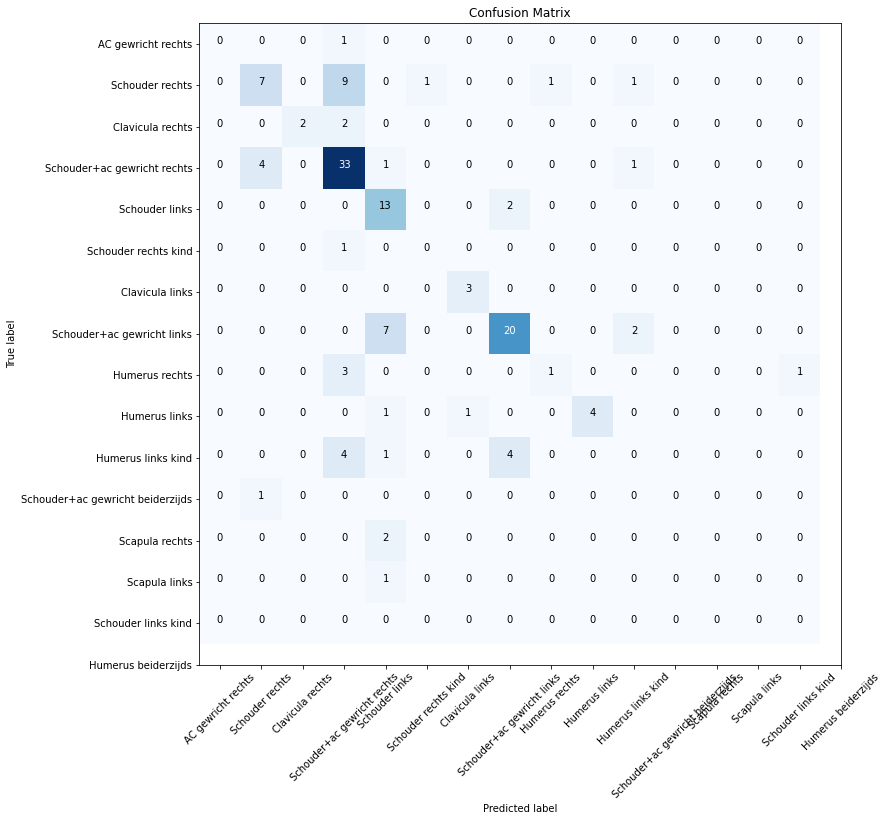

In [32]:
node.classifier.evaluate(testsubset, verbosity=2, plot_cm=True)

From the confusion matrix we can see that the classifier struggles with the class "Bekken+heup beiderzijds" and often incorrect classifies it as either "Bekken+heup links' or "Bekken+heup rechts". This makes sense, because when the StudyDescription is "Beiderzijds" (Dutch for "both sides") images of both sides are made but not a single image of both sides! (See plotted image below of class "Bekken+heup beiderzijds") 

In [ ]:
# Plot an image with StudyDescription == Bekken+heup beiderzijds
trainsubset.subset({'StudyDescription': 'Bekken+heup beiderzijds'}).plot_one_of_every('StudyDescription')

This means there is no way for a classifier to tell if an image is "Beiderzijds" or not in the first place, as it only classifies a single image at the time. We should therefore exclude this class from training and evaluating. To do so, we first construct new constaints:

In [ ]:
classes = node.classifier.classes
classes.remove

constraints['StudyDescription'] = classes

pprint(constraints)

In [ ]:
# When doing this, the removed classes will be automatically excluded from evaluation and training data
node.dataset_constraints = constraints

# Assign new classifier to the node
node.classifier = newnet